In [1]:
import numpy as np
import math
import gym
from gym import spaces
import time
import random
from stable_baselines3 import A2C, SAC,PPO
import torch
import matplotlib.pyplot as plt
import heapq
from stable_baselines3.common.env_checker import check_env
from mpl_toolkits.mplot3d import Axes3D
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import os

In [3]:
torch.__version__

'1.13.1'

In [4]:
gym.__version__

'0.21.0'

In [5]:
%matplotlib inline

## Finite Element Model of the Space Frame Element

In [6]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [7]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [8]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [9]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d

In [10]:
# 10 The Space Frame Element - verification
d=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [11]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Utils

In [12]:
def total_length(coord,elcon):
    coord=np.array(coord)
    elcon=np.array(elcon)
    t_length=0
    for i in range(len(elcon)):
        l=PlaneTrussElementLength(coord[elcon[i][0]][0],\
                                    coord[elcon[i][0]][1],\
                                    coord[elcon[i][0]][2],\
                                    coord[elcon[i][1]][0],\
                                    coord[elcon[i][1]][1],\
                                    coord[elcon[i][1]][2])
        t_length+=l        
    return t_length    

In [13]:
def possible_lines_dic(n,m,dx,dy):
    A=[(-dx,0),(-dx,dy),(0,dy),(dx,dy),(dx,0),(dx,-dy),(0,-dy),(-dx,-dy)]
    dic={}
    t=0
    for i in range(n):
        for j in range(m):
            for item in A:
                x,y=j*dx,i*dy
                x1,y1=x+item[0],y+item[1]
                if (x1>=0 and x1<=(m-1)*dx and 
                    y1>=0 and y1<=(n-1)*dy and 
                    (x1,y1,x,y) not in dic):
                    dic[(x,y,x1,y1)]=t
                    t+=1
    return dic                

In [14]:
DIM = len(possible_lines_dic(n=5,m=5,dx=1,dy=1)) + 3 # +2 for x and y +1 for action

## Model

In [15]:
class Model:
    def __init__(self,n=5,m=5,dx=1,dy=1, force=-500,
                 E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5, break_flag=False):
        # n,m,dx,dy - grid parameters    
        self.E=E
        self.G=G
        self.A=A
        self.Iy=Iy
        self.Iz=Iz
        self.J=J
        self.n=n
        self.m=m
        self.dx=dx
        self.dy=dy
        self.dic_lines=possible_lines_dic(self.n,self.m,self.dx,self.dy)
        self.line_list=len(self.dic_lines)*[0]
        self.break_flag=break_flag
        self.coord=[[2,2,0]]    
        self.elcon=[]  
        self.el_dic={(2,2):0}
        self.max_el=0
        self.force=force
        self.bc_node = []
        self.bc_val = []
        self.global_force = [0, self.force, 0, 0, 0, 0]
        self.old_weight=float("inf")
        self.old_strength=-float("inf")
        self.visit_list = [0,0,0,0] # number of checkpoints is 4
    
    def reset(self,break_flag,force):
        self.dic_lines=possible_lines_dic(self.n, self.m, self.dx, self.dy)
        self.line_list=len(self.dic_lines)*[0]
        self.break_flag=break_flag
        self.coord=[[2,2,0]]    
        self.elcon=[]  
        self.el_dic={(2,2):0}
        self.max_el=0
        self.force=force
        self.bc_node = []
        self.bc_val = []
        self.global_force = [0, self.force, 0, 0, 0, 0]
        self.visit_list = [0,0,0,0] # number of checkpoints is 4
    
    def FEA(self):
        return FEA_u(self.coord, 
                     self.elcon, 
                     self.bc_node, 
                     self.bc_val, 
                     self.global_force, )
        
    def max_u(self, FEA_output_arr):
        t=1
        A=[]
        while t<len(FEA_output_arr):
            A.append(FEA_output_arr[t])
            t+=6            
        return min(A)    
            
    
    def length(self):
        return total_length(self.coord,self.elcon)
    
    
    def move_w(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
            
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1
            
        return x_new, y_new
            
    def move_nw(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]]) 
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1    
                
        return x_new, y_new
    
    def move_n(self,x,y):
        # x,y - current location
        x_new=x
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1     
        
        return x_new, y_new
    
    
    def move_ne(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y+self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                        
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1     
                  
        return x_new, y_new
    
    def move_e(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                       
                  
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])   
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        return x_new, y_new
    
    def move_se(self,x,y):
        # x,y - current location
        x_new=x+self.dx
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        
        return x_new, y_new
    
    def move_s(self,x,y):
        # x,y - current location
        x_new=x
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True 
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
            
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1      
        
        return x_new, y_new
    
    def move_sw(self,x,y):
        # x,y - current location
        x_new=x-self.dx
        y_new=y-self.dy
        if x_new<0 or x_new>(self.m-1)*self.dx or y_new<0 or y_new>(self.n-1)*self.dy \
        or 3 in self.line_list:
            self.break_flag=True
        else:
            try:
                self.line_list[self.dic_lines[(x,y,x_new,y_new)]]+=1
            except KeyError:
                self.line_list[self.dic_lines[(x_new,y_new, x,y)]]+=1
                        
            if (x_new,y_new) not in self.el_dic:
                self.max_el+=1
                self.el_dic[(x_new,y_new)]=self.max_el
                self.coord.append([x_new,y_new,0])
                if (x_new,y_new)!=(1,1) and (x_new,y_new)!=(self.m-2,1) and \
                    (x_new,y_new)!=(self.m-2,self.n-2) and \
                    (x_new,y_new)!=(1,self.n-2):
                    self.global_force += [0,self.force,0,0,0,0]
                elif (x_new,y_new)==(1,1) or (x_new,y_new)==(self.m-2,1) or \
                    (x_new,y_new)==(self.m-2,self.n-2) or \
                    (x_new,y_new)==(1,self.n-2):
                    range_ = list(range(self.el_dic[(x_new,y_new)]*6-6,self.el_dic[(x_new,y_new)]*6))
                    self.bc_node += range_
                    self.bc_val += [0]*len(range_)
                    self.global_force += [0,0,0,0,0,0]
                        
            if  (self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]) not in self.elcon and \
                 (self.el_dic[(x_new,y_new)],self.el_dic[(x,y)]) not in self.elcon:
                self.elcon.append([self.el_dic[(x,y)], self.el_dic[(x_new,y_new)]])
                  
                  
            if (x_new,y_new) in self.el_dic:
                if (x_new,y_new)==(1,1):
                    self.visit_list[0]+=1
                elif (x_new,y_new)==(self.m-2,1):
                    self.visit_list[1]+=1
                elif (x_new,y_new)==(self.m-2,self.n-2):
                    self.visit_list[2]+=1
                elif (x_new,y_new)==(1,self.n-2):
                    self.visit_list[3]+=1    
                                  
        return x_new, y_new
    
        
    def action_space(self,action,x0,y0):
        if action==0:
            return self.move_w(x0,y0)
        elif action==1:    
            return self.move_nw(x0,y0)
        elif action==2:  
            return self.move_n(x0,y0)
        elif action==3:
            return self.move_ne(x0,y0)
        elif action==4:
            return self.move_e(x0,y0)
        elif action==5:
            return self.move_se(x0,y0)
        elif action==6:
            return self.move_s(x0,y0)
        elif action==7:
            return self.move_sw(x0,y0)
                        
    
    def nn_input(self,x,y,action):  
        return self.line_list+[x,y]+[action]        
    
    def reward_(self,x_new,y_new,n_steps):
        reward=2*n_steps
        if all([x>=1 for x in self.visit_list]):
            reward+=100
            weight=self.length()
        
            FEA_output_arr=self.FEA()
            max_=self.max_u(FEA_output_arr)
            strength=max_
            if weight<=self.old_weight:
                reward+=500
                self.old_weight=weight
            if strength>=self.old_strength: 
                reward+=1000
                self.old_strength=strength        
            self.break_flag=True     
            return reward 
        return reward     
                                   
    def draw(self,color):
        c=self.coord
        e=self.elcon
        c=np.array(c)
        e=np.array(e)
        coord=c.reshape(np.max(e)+1,3)
        fig=plt.figure(figsize=(13,5))
        for item in e:
            ax = fig.gca(projection='3d') 
            ax.plot([coord[item[0]][0],coord[item[1]][0]],\
                     [coord[item[0]][1],coord[item[1]][1]],\
                     [coord[item[0]][2],coord[item[1]][2]],
                     color=color) 
        ax.view_init(-90,90)
        ax.set_xlim([0, 5])
        ax.set_ylim([0, 5])
        plt.show()             

## Reinforcement learning model

In [16]:
N_DISCRETE_ACTIONS=8

In [17]:
class BionicEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.M=Model()
        self.M.reset(False,-500)
        self.x0=2
        self.y0=2
        self.obs=self.M.nn_input(self.x0,self.y0, 0)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.int64)
        self.step_=0
        self.needs_reset = True

    def step(self, action):
        
        x_new, y_new = self.x0, self.y0 
        x_new, y_new = self.M.action_space(action, x_new, y_new)
        self.obs=self.M.nn_input(x_new,y_new,action)
                
        self.step_+=1           
        reward=self.M.reward_(x_new,y_new,self.step_)
        self.x0,self.y0 = x_new,y_new
        
        done=False
        if self.M.break_flag:
            reward-=100
            done=True
        
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
      
        return np.array(self.obs), reward, done, dict()

    def reset(self):
        self.M.reset(False,-500)
        self.x0=2
        self.y0=2
        self.obs=self.M.nn_input(self.x0,self.y0,0)
        self.step_=0
        self.needs_reset = False
        return np.array(self.obs)  

    def render(self, mode="human"):
        self.M.draw('blue')    

    def close(self):
        pass

In [18]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [19]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BionicEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

In [20]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [21]:
ts=5e5

In [22]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -10.16
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: -10.16 - Last mean reward per episode: -29.22
Num timesteps: 3000
Best mean reward: -10.16 - Last mean reward per episode: -27.28
Num timesteps: 4000
Best mean reward: -10.16 - Last mean reward per episode: -6.06
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: -6.06 - Last mean reward per episode: 4.32
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 6000
Best mean reward: 4.32 - Last mean reward per episode: 8.86
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 7000
Best mean reward: 8.86 - Last mean reward per episode: 37.70
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 8000
Best mean reward: 37.70 - Last mean reward per episode: 26.76
Num timesteps: 9000
Best mean reward: 37.70 - Last mean reward per episode: 41.22
Saving new best 

Num timesteps: 82000
Best mean reward: 465.08 - Last mean reward per episode: 453.60
Num timesteps: 83000
Best mean reward: 465.08 - Last mean reward per episode: 438.52
Num timesteps: 84000
Best mean reward: 465.08 - Last mean reward per episode: 395.12
Num timesteps: 85000
Best mean reward: 465.08 - Last mean reward per episode: 417.90
Num timesteps: 86000
Best mean reward: 465.08 - Last mean reward per episode: 411.62
Num timesteps: 87000
Best mean reward: 465.08 - Last mean reward per episode: 438.82
Num timesteps: 88000
Best mean reward: 465.08 - Last mean reward per episode: 455.16
Num timesteps: 89000
Best mean reward: 465.08 - Last mean reward per episode: 442.54
Num timesteps: 90000
Best mean reward: 465.08 - Last mean reward per episode: 500.92
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 91000
Best mean reward: 500.92 - Last mean reward per episode: 496.44
Num timesteps: 92000
Best mean reward: 500.92 - Last mean reward per episode: 510.08
Saving new best 

Num timesteps: 175000
Best mean reward: 678.70 - Last mean reward per episode: 580.40
Num timesteps: 176000
Best mean reward: 678.70 - Last mean reward per episode: 603.48
Num timesteps: 177000
Best mean reward: 678.70 - Last mean reward per episode: 610.00
Num timesteps: 178000
Best mean reward: 678.70 - Last mean reward per episode: 628.68
Num timesteps: 179000
Best mean reward: 678.70 - Last mean reward per episode: 636.60
Num timesteps: 180000
Best mean reward: 678.70 - Last mean reward per episode: 621.92
Num timesteps: 181000
Best mean reward: 678.70 - Last mean reward per episode: 668.62
Num timesteps: 182000
Best mean reward: 678.70 - Last mean reward per episode: 664.76
Num timesteps: 183000
Best mean reward: 678.70 - Last mean reward per episode: 642.98
Num timesteps: 184000
Best mean reward: 678.70 - Last mean reward per episode: 604.44
Num timesteps: 185000
Best mean reward: 678.70 - Last mean reward per episode: 653.62
Num timesteps: 186000
Best mean reward: 678.70 - Last 

Num timesteps: 266000
Best mean reward: 849.60 - Last mean reward per episode: 762.34
Num timesteps: 267000
Best mean reward: 849.60 - Last mean reward per episode: 751.18
Num timesteps: 268000
Best mean reward: 849.60 - Last mean reward per episode: 801.80
Num timesteps: 269000
Best mean reward: 849.60 - Last mean reward per episode: 808.32
Num timesteps: 270000
Best mean reward: 849.60 - Last mean reward per episode: 749.86
Num timesteps: 271000
Best mean reward: 849.60 - Last mean reward per episode: 712.14
Num timesteps: 272000
Best mean reward: 849.60 - Last mean reward per episode: 729.44
Num timesteps: 273000
Best mean reward: 849.60 - Last mean reward per episode: 773.48
Num timesteps: 274000
Best mean reward: 849.60 - Last mean reward per episode: 823.02
Num timesteps: 275000
Best mean reward: 849.60 - Last mean reward per episode: 796.66
Num timesteps: 276000
Best mean reward: 849.60 - Last mean reward per episode: 809.56
Num timesteps: 277000
Best mean reward: 849.60 - Last 

Num timesteps: 359000
Best mean reward: 989.64 - Last mean reward per episode: 863.30
Num timesteps: 360000
Best mean reward: 989.64 - Last mean reward per episode: 929.22
Num timesteps: 361000
Best mean reward: 989.64 - Last mean reward per episode: 940.24
Num timesteps: 362000
Best mean reward: 989.64 - Last mean reward per episode: 970.64
Num timesteps: 363000
Best mean reward: 989.64 - Last mean reward per episode: 938.50
Num timesteps: 364000
Best mean reward: 989.64 - Last mean reward per episode: 919.18
Num timesteps: 365000
Best mean reward: 989.64 - Last mean reward per episode: 917.72
Num timesteps: 366000
Best mean reward: 989.64 - Last mean reward per episode: 944.42
Num timesteps: 367000
Best mean reward: 989.64 - Last mean reward per episode: 980.04
Num timesteps: 368000
Best mean reward: 989.64 - Last mean reward per episode: 1004.20
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 369000
Best mean reward: 1004.20 - Last mean reward per episode: 999.16
Num

Num timesteps: 449000
Best mean reward: 1152.42 - Last mean reward per episode: 1068.02
Num timesteps: 450000
Best mean reward: 1152.42 - Last mean reward per episode: 987.32
Num timesteps: 451000
Best mean reward: 1152.42 - Last mean reward per episode: 952.88
Num timesteps: 452000
Best mean reward: 1152.42 - Last mean reward per episode: 936.20
Num timesteps: 453000
Best mean reward: 1152.42 - Last mean reward per episode: 994.54
Num timesteps: 454000
Best mean reward: 1152.42 - Last mean reward per episode: 1050.24
Num timesteps: 455000
Best mean reward: 1152.42 - Last mean reward per episode: 1080.44
Num timesteps: 456000
Best mean reward: 1152.42 - Last mean reward per episode: 1052.26
Num timesteps: 457000
Best mean reward: 1152.42 - Last mean reward per episode: 1082.50
Num timesteps: 458000
Best mean reward: 1152.42 - Last mean reward per episode: 1051.74
Num timesteps: 459000
Best mean reward: 1152.42 - Last mean reward per episode: 1028.08
Num timesteps: 460000
Best mean rewa

In [23]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 13.099966629346211 min


### Design by AI

In [24]:
obs = env.reset()

In [25]:
i=0
while i<100:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    if env.M.break_flag:
        break
    i+=1   

In [26]:
print(i)

29


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:478: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


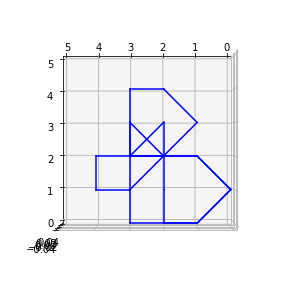

In [27]:
env.render() 

In [28]:
env.M.length()

32.72792206135786

In [29]:
FEA_output_arr=env.M.FEA()
env.M.max_u(FEA_output_arr)

-0.008661375931081464

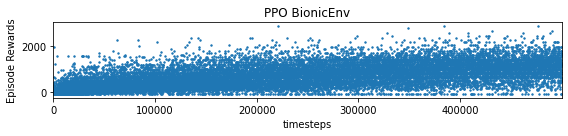

In [30]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "PPO BionicEnv")